In [29]:
import random
import warnings
import numpy as np
import pandas as pd

import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [30]:
%matplotlib inline

random.seed(9001)
color = sns.color_palette()
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
# import dataset
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [4]:
print("The order_products_train size is : ", order_products_train.shape[0])
print("The order_products_prior size is : ", order_products_prior.shape[0])

The order_products_train size is :  1384617
The order_products_prior size is :  32434489


   user_id  order_hour_min  order_hour_mean  order_hour_max
0        1               7           10.091              16
1        2               9           10.600              15
2        3              14           16.308              19
3        4              11           12.500              15
4        5              11           15.000              18


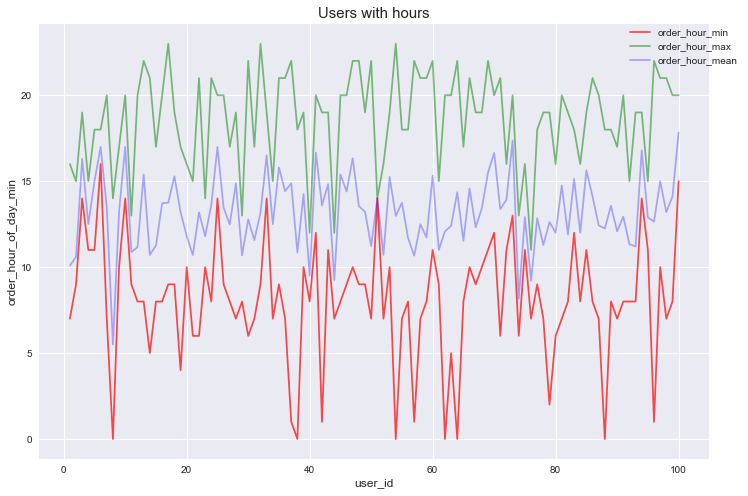

In [5]:
# user order time
grouped = orders.groupby("user_id")["order_hour_of_day"].aggregate({'order_hour_min': 'min', 'order_hour_mean': 'mean', 'order_hour_max': 'max'}).reset_index()
print(grouped.head(5))

grouped_df = grouped.iloc[:100, :]
plt.figure(figsize=(12,8))
plot1 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_min"], "r", alpha = 0.7)
plot2 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_max"], "g", alpha = 0.5)
plot3 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_mean"], "b", alpha = 0.3)

plt.ylabel('order_hour_of_day_min', fontsize = 12)
plt.xlabel('user_id', fontsize = 12)
plt.title("Users with hours", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc = 1, borderaxespad = 0.1)
plt.show()

> 不同客戶的購買時間(1~100)

In [6]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis = 0)

print("The order_products_all size is : ", order_products_all.shape[0])

The order_products_all size is :  33819106


In [7]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


In [8]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by = 'Total_reorders', ascending = False)
grouped.head(10)

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


> 商品熱門排行榜

In [9]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how = 'left', on = ['product_id'])
grouped = grouped.sort_values(['reorder_probability'], ascending = False)
grouped.head(10)

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
6431,6433,65,69,0.942,Raw Veggie Wrappers
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
43550,43553,12,13,0.923,Orange Energy Shots
27737,27740,94,102,0.922,Chocolate Love Bar
14606,14609,32,35,0.914,Soy Powder Infant Formula
13872,13875,41,45,0.911,Simply Sleep Nighttime Sleep Aid
39989,39992,20,22,0.909,"Energy Shot, Grape Flavor"
5866,5868,27,30,0.900,Russian River Valley Reserve Pinot Noir
36540,36543,62,69,0.899,Bars Peanut Butter
26090,26093,60,67,0.896,Soy Crisps Lightly Salted


> 商品重複購買排行榜

### merge

In [10]:
# merge order_products_prior and orders
order_products_prior_df = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')
print(order_products_prior_df.shape)
order_products_prior_df.head()

(32434489, 10)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.000
1,2,28985,2,1,202279,prior,3,5,9,8.000
2,2,9327,3,0,202279,prior,3,5,9,8.000
3,2,45918,4,1,202279,prior,3,5,9,8.000
4,2,30035,5,0,202279,prior,3,5,9,8.000


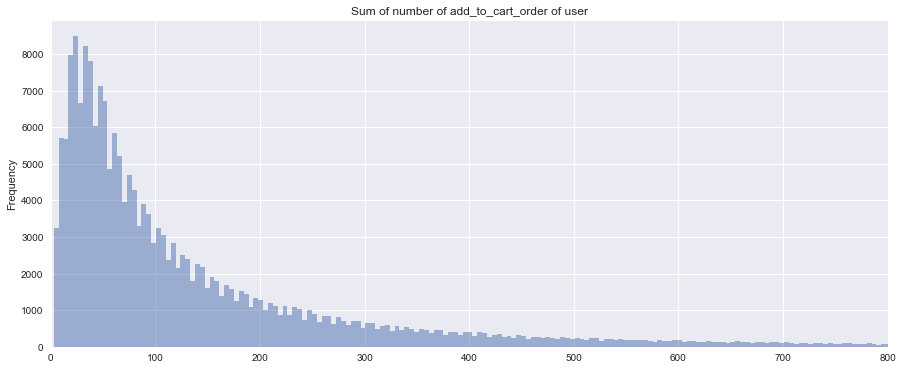

Total Order Product Number of User
Size of user : 206209
Size of total order product <20 user  : 20974
Size of total order product >500 user : 13305


In [47]:
cnt_srs = order_products_prior_df.groupby(["user_id", "order_id"])["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs1 = cnt_srs.groupby(["user_id"])["add_to_cart_order"].aggregate("sum").reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
cnt_srs1.add_to_cart_order.plot(kind="hist", ax = ax,
                                title="Sum of number of add_to_cart_order of user",
                                bins=800, alpha=0.5)
plt.xlim(0, 800)
plt.show()

print("Total Order Product Number of User")
print("Size of user :",cnt_srs1.shape[0])
print("Size of total order product <20 user  :",cnt_srs1[cnt_srs1.add_to_cart_order <= 20].shape[0])
print("Size of total order product >500 user :",cnt_srs1[cnt_srs1.add_to_cart_order >= 500].shape[0])

> user_id當作樞紐，每個人總購買數量總數的分佈。方便刪除不重要的user，跟找出重要user。最資料刪減減少noise

In [12]:
# merge order_product_pirior and products
order_products_prior_df = pd.merge(order_products_prior_df, products, on='product_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.000,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.000,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.000,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.000,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.000,Natural Sweetener,17,13


     aisle_id  department_id  reorder_sum  reorder_count  reordered_ratio
83         84             16       696264         891015            0.781
114       115              7       613977         841533            0.730
23         24              4      2615469        3642188            0.718
85         86             16       318920         452134            0.705
90         91             16       442023         638253            0.693


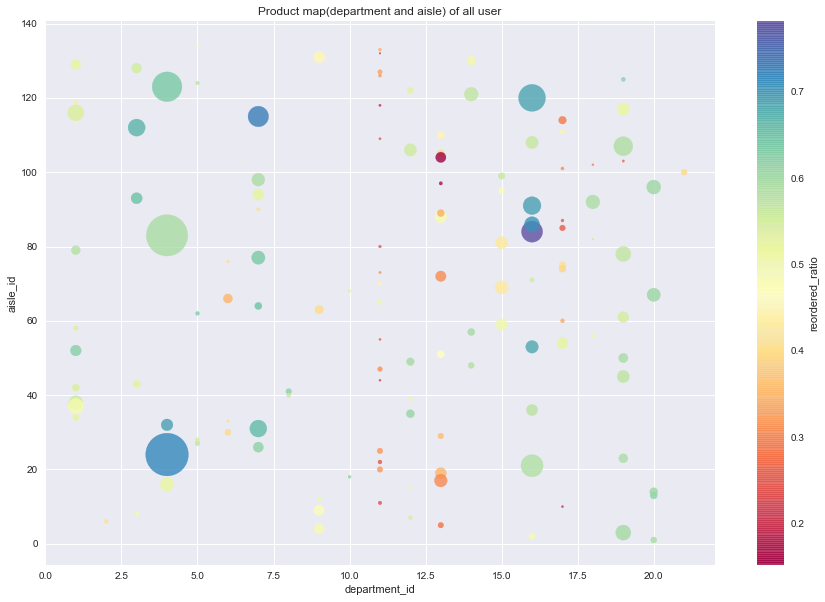

In [13]:
f = {'reordered':['sum','count']}
grouped_df = order_products_prior_df.groupby(["aisle_id", "department_id"]).aggregate(f).reset_index()
grouped_df.columns = ["aisle_id", "department_id", "reorder_sum", "reorder_count"]
grouped_df["reordered_ratio"] = grouped_df.reorder_sum/grouped_df.reorder_count
grouped_df = grouped_df.sort_values(by = 'reordered_ratio', ascending = False)
print(grouped_df.head())

fig, ax = plt.subplots(figsize=(15, 10))
cmap = cm.get_cmap('Spectral')
grouped_df.plot(x='department_id', y='aisle_id', ax = ax,
                title="Product map(department and aisle) of all user",
                kind='scatter', s=grouped_df['reorder_count']*0.0005, c='reordered_ratio',
                cmap=cmap, alpha=0.8)
ax.set_xlabel("department_id")
plt.show()

> 像地圖一樣，標出每區reorder的比例。找出較常購買的區域，也找出熱門和冷門區域。

### Focus on user_id

In [14]:
user_id = 3000

df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]
df_user = df_user.sort_values(by = ['order_number', 'add_to_cart_order'], ascending = True)
orders_Unique = len(set(df_user.order_id))

#df_user = pd.merge(df_user, products, on='product_id', how='left')
df_user = pd.merge(df_user, aisles, on='aisle_id', how='left')
df_user = pd.merge(df_user, departments, on='department_id', how='left')
print("Number of order :", orders_Unique)
print("number of ordered product :", df_user.shape[0])
df_user.head()

Number of order : 18
number of ordered product : 264


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,3057731,47626,1,0,3000,prior,1,3,7,nan,Large Lemon,24,4,fresh fruits,produce
1,3057731,1313,2,0,3000,prior,1,3,7,nan,Tortilla Strips Restaurant Style,107,19,chips pretzels,snacks
2,3057731,30776,3,0,3000,prior,1,3,7,nan,Organic Raw Kombucha Gingerade,31,7,refrigerated,beverages
3,3057731,49683,4,0,3000,prior,1,3,7,nan,Cucumber Kirby,83,4,fresh vegetables,produce
4,3057731,46294,5,0,3000,prior,1,3,7,nan,Organic Parsley,16,4,fresh herbs,produce


    aisle_id  department_id  reorder_sum  reorder_count  reordered_ratio
19        83              4           40             64            0.625
5         24              4           22             29            0.759
8         31              7           14             21            0.667
33       123              4           13             18            0.722
2         16              4            9             14            0.643


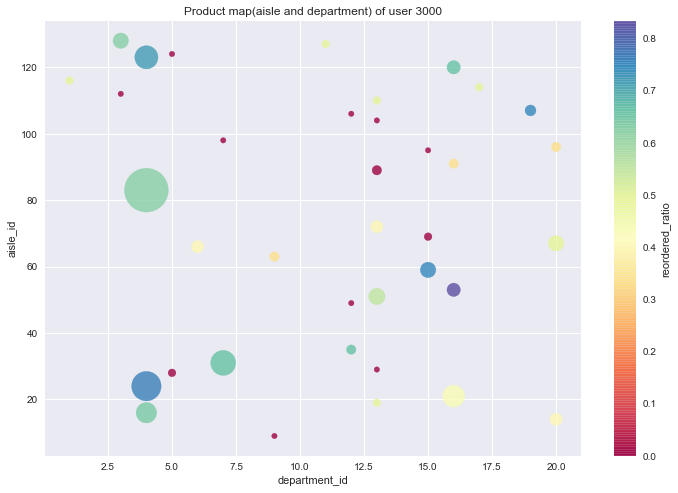

In [15]:
f = {'reordered':['sum','count']}
grouped_df = df_user.groupby(["aisle_id", "department_id"]).aggregate(f).reset_index()
grouped_df.columns = ["aisle_id", "department_id", "reorder_sum", "reorder_count"]
grouped_df["reordered_ratio"] = grouped_df.reorder_sum/grouped_df.reorder_count
grouped_df = grouped_df.sort_values(by = 'reorder_sum', ascending = False)
print(grouped_df.head())

import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

fig, ax = plt.subplots(figsize=(12, 8))
grouped_df.plot(x='department_id', y='aisle_id', ax = ax,
                title="Product map(aisle and department) of user " + str(user_id),
                kind='scatter', s=grouped_df['reorder_count']*30, c='reordered_ratio',
                cmap=cmap, alpha=0.8)
plt.show()    

> 用地圖的方式呈現該消費者傾像購買的貨櫃架跟部門

     product_id  aisle_id  reorder_sum  reorder_count  reordered_ratio
110       49683        83            8              9            0.889
74        36685       123            8              9            0.889
18        10411        83            6              7            0.857
102       47626        24            6              7            0.857
6          5450        24            6              7            0.857


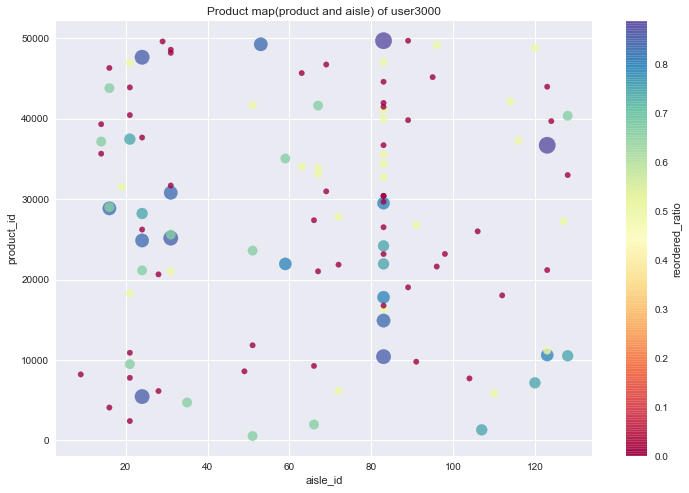

In [16]:
f = {'reordered':['sum','count']}
grouped_df = df_user.groupby(["product_id", "aisle_id", "department_id"]).aggregate(f).reset_index()
grouped_df.columns = ["product_id", "aisle_id", "department_id", "reorder_sum", "reorder_count"]
grouped_df["reordered_ratio"] = grouped_df.reorder_sum/grouped_df.reorder_count

grouped_df = grouped_df.sort_values(by = 'reorder_sum', ascending = False)
grouped_df = grouped_df.drop(["department_id"], axis=1)
print(grouped_df.head())

import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

fig, ax = plt.subplots(figsize=(12, 8))
grouped_df.plot(x='aisle_id', y='product_id', ax = ax,
                title="Product map(product and aisle) of user" + str(user_id),
                kind='scatter', s=grouped_df['reorder_count']*30, c='reordered_ratio',
                cmap=cmap, alpha=0.8)
plt.show()    

> 該消費者最愛購買的商品。